In [106]:
import numpy as np
import pandas as pd
from scipy import optimize
import scipy as sc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
import statsmodels.api as sm

## Exercise 2

#### Load Breast Cancer Survival Data

In [107]:
url_hospital = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
data1 = pd.read_csv(url_hospital, header=None,
        names=['age', 'year', 'nodes_detected', 'survival_status'])
data1.head()

,age,year,nodes_detected,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [108]:
# define data and create train test splits
X = data1.loc[:,['age', 'nodes_detected']].values
y = data1.survival_status.replace(2, 0).values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.33, random_state=1)

We compute the solutions from first principles, using standard python functions. The accompanying chapter in Bishop is 4.2.2. In our setting we have a binary (2-class) classification problem with a sample size 𝑛 n . Our date consistts of pairs of labels and features {(𝑦1,𝑥1),…,(𝑦𝑛,𝑥𝑛)} { ( y 1 , x 1 ) , … , ( y n , x n ) } where 𝑦𝑖∈{0,1} y i ∈ { 0 , 1 } and 𝑥𝑖∈𝑅𝑚 x i ∈ R m . We are interested in the probability 𝑝(𝑦=1|𝑥) p ( y = 1 | x ) . The formulas used are the following equations in Bishop Prior probability of class 0 : 4.73 Mean of features 4.75, 4.76 Covariance matrix 4.78 which we implement below.

In [109]:
def prior_prob_class(y):
    N1 = len(y[y==0])
    N2 = len(y[y==1])
    return N1/(N1+N2), 1-N1/(N1+N2)

pi = prior_prob_class(y_train)
pi

(0.2634146341463415, 0.7365853658536585)

In [110]:
def mu_mle(x,y): 
    mu0 = np.mean(x[y==0], axis=0)
    mu1 = np.mean(x[y==1], axis=0)
    return mu0, mu1

mu0, mu1 = mu_mle(X_train, y_train)
print(mu0, mu1)

[51.7037037   7.12962963] [52.87417219  2.37086093]


In [111]:
def S_mle(x, y): 
    N = len(y)
    N1 = len(y[y==1])
    N0 = N - N1
    k = x.shape[1]

    S0 = np.zeros((k,k))
    S1 = np.zeros((k,k))
    for i in range(int(N)):
        if y[i] == 0:
            S0 += np.outer((x[i] - mu0), (x[i] - mu0))
        else: 
            S1 += np.outer((x[i] - mu1), (x[i] - mu1))
    S = (S0 + S1)/N
    return S

S = S_mle(X_train, y_train)
S

array([[1.08692042e+02, 7.86362521e-02],
       [7.86362521e-02, 4.02113384e+01]])

## Exercise 3

#### Load Credit Card Fraud data

In [112]:
fraud = pd.read_csv('CreditCardFraud.csv')
X = fraud.drop('Class', axis = 1)
y = fraud['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
n,p = X_train.shape

### Logistic Regression with MLE

In [113]:
logreg = LogisticRegression(fit_intercept=True,solver='lbfgs')
logreg.fit(X_train,y_train)
intercept = np.array([logreg.intercept_])[0,]
coef = np.array(logreg.coef_)[0,].T
beta_mle = np.hstack((intercept,coef))
print(beta_mle)

[-4.7776037   0.37510892 -0.32791254 -0.86897572  0.98390799  0.41668093
 -0.23474311  0.14066784 -0.33407644 -0.13633943 -0.86024711 -0.13711604
 -0.76939973 -0.44560518 -0.35924513 -0.82105228 -0.08766075 -0.08616026
 -0.08874027  0.34998046 -0.46553723  0.5435613   1.37169911 -0.12796092
 -0.32440358 -0.33315859  0.11380487 -1.17870128 -0.28213361]


The following code is only used to add a column of ones to X_test

In [114]:
n = len(fraud['Class'])
fraud['x0'] = np.ones(n)
X = fraud.drop('Class', axis = 1)
y = fraud['Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
n,p = X_train.shape

#### Assess predictive ability

0.4873035066505441 5113.0830518255825
0.8189789123196447


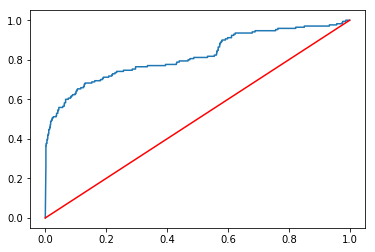

In [115]:
predict_probs = sigma(X_test,beta_mle)
predict_class = (predict_probs > .5)
print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,predict_probs)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,predict_probs)
print(AUC_MLE)

### Bayesian Logistic Regression via Laplace approximation

In [116]:
def sigma(x,beta):
    xbeta = x.dot(beta)
    d = 1. + np.exp(-xbeta)
    return d**(-1)
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t
def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y)+S0.dot(beta-m0)
def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec
def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [117]:
n,p = X_train.shape
beta0 = np.zeros(p)
m0 = np.zeros(p)
S0 = X_train.T.dot(X_train)/n
tolerance = 1e-05
maxiter = 100 
beta = beta0
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,X_train,y_train,m0,S0,maxiter,tolerance)
print(beta_map)

iteration  1  Negative Log Posterior  2326.2019379591784  AbDiff  1
iteration  2  Negative Log Posterior  611.9659769930406  AbDiff  1714.2359609661378
iteration  3  Negative Log Posterior  331.3039998927475  AbDiff  280.6619771002931
iteration  4  Negative Log Posterior  227.55366144428604  AbDiff  103.75033844846149
iteration  5  Negative Log Posterior  187.7423571402583  AbDiff  39.81130430402774
iteration  6  Negative Log Posterior  177.15594915857793  AbDiff  10.586407981680367
iteration  7  Negative Log Posterior  175.80725140199107  AbDiff  1.3486977565868585
iteration  8  Negative Log Posterior  175.774316178659  AbDiff  0.03293522333206056
iteration  9  Negative Log Posterior  175.7742850747206  AbDiff  3.1103938397336606e-05
[ 0.28198824 -0.24036034 -0.76481527  0.77673163  0.37142469 -0.23824019
  0.18405456 -0.24565343 -0.03413525 -0.60253519 -0.10885629 -0.62428908
 -0.37918444 -0.33015746 -0.7030513  -0.02692901 -0.06333472 -0.03785163
  0.23129721 -0.31270675  0.48423596

#### Assess predictive ability

0.9891172914147521 81.04307985456133
0.9872681147930872


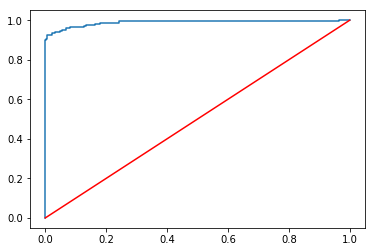

In [118]:
N = 10000 #number of Monte Carlo samples
betas = np.random.multivariate_normal(beta_map,cov,N)
Xbetas = X_test.dot(betas.T)
d = 1/(1. + np.exp(-Xbetas))
pred_probs_blr = np.mean(d, axis=1)
pred_class_blr = (pred_probs_blr > .5)

print(accuracy_score(y_test,pred_class_blr), log_loss(y_test, pred_probs_blr, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,pred_probs_blr)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_BLR = roc_auc_score(y_test,pred_probs_blr)
print(AUC_BLR)

## Exercise 4

#### Load Default Data

In [119]:
default = pd.read_csv('Default.csv', header=None,
    names=['default','balance','income'])
n = len(default['default'])
default['x0'] = np.ones(n)
predictors = ['x0','balance', 'income']
target = ['default']
X_train, X_test, y_train, y_test = train_test_split(default[predictors],
                        default[target],test_size=0.5, random_state=1)
n,p = X_train.shape

### Logistic regression via MLE

In [120]:
def sigma(x,beta):
    xbeta = x.dot(beta)
    d = 1. + np.exp(-xbeta)
    return d**(-1)
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t
def fprime(beta,x,y):
    return  x.T.dot(sigma(x,beta)-y)
def Hessian(beta,x):  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    hes = x.T.dot(S.dot(x))
    return hes
def NewtonRaphsonLogistReg(beta0,x,y,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogLike = nll(beta,x,y)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log likelihood ',NegLogLike, ' AbDiff ', AbDiff)
        grad = fprime(beta,x,y)
        H = Hessian(beta,x)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogLike_new = nll(beta,x,y)
        AbDiff = np.abs(NegLogLike_new-NegLogLike)
        NegLogLike = NegLogLike_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [121]:
n,p = X_train.shape
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta = beta0
beta_mle, cov = NewtonRaphsonLogistReg(beta0,X_train,y_train['default'],maxiter,tolerance)
print(beta_mle)

iteration  1  Negative Log likelihood  3465.7359027997277  AbDiff  1
iteration  2  Negative Log likelihood  979.1317064957278  AbDiff  2486.6041963039997
iteration  3  Negative Log likelihood  618.4035486691278  AbDiff  360.72815782660007
iteration  4  Negative Log likelihood  472.3712181591759  AbDiff  146.03233050995186
iteration  5  Negative Log likelihood  413.267313612353  AbDiff  59.10390454682289
iteration  6  Negative Log likelihood  397.0260718349252  AbDiff  16.24124177742783
iteration  7  Negative Log likelihood  395.1729189864142  AbDiff  1.8531528485110016
iteration  8  Negative Log likelihood  395.1389735528322  AbDiff  0.03394543358194824
iteration  9  Negative Log likelihood  395.1389594614442  AbDiff  1.409138803865062e-05
[-1.16341953e+01  5.84263038e-03  1.63504439e-05]


Check by using yhe **statsmodels** library

In [123]:
predictors = ['balance','income']
Xt = X_train[predictors]
Xt = sm.add_constant(Xt)
yt = y_train['default']
model = sm.Logit(yt, Xt).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.079028
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Tue, 24 Dec 2019   Pseudo R-squ.:                  0.4768
Time:                        00:02:53   Log-Likelihood:                -395.14
converged:                       True   LL-Null:                       -755.25
                                        LLR p-value:                4.024e-157
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6342      0.620    -18.763      0.000     -12.850     -10.419
balance        0.0058      0.000     17.791      0.000       0.005       0.006
income      1.635e-05   7.15e-06      2.287      0.022    2.34e-06    3.04e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### Assess predictive ability

0.975 default    395.960166
dtype: float64
0.9436183854107798


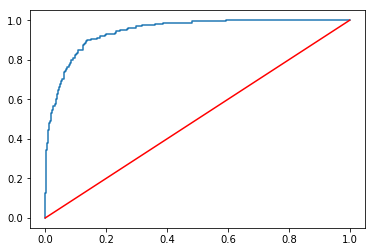

In [124]:
predict_probs = sigma(X_test,beta_mle)
predict_class = (predict_probs > .5)

AccRate_MLE = np.sum(predict_class==y_test['default'])/len(y_test) 
LS_MLE = -(y_test.T.dot(np.log(predict_probs))+(1-y_test).T.dot(np.log(1-predict_probs)))

print(AccRate_MLE, LS_MLE)
#print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,predict_probs)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,predict_probs)
print(AUC_MLE)

### Bayesian Logistic Regression via Laplace

In [125]:
def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y)+S0.dot(beta-m0)
def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec
def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [126]:
n,p = X_train.shape
beta0 = np.zeros(p)
m0 = np.zeros(p)
S0 = X_train.T.dot(X_train)/n
tolerance = 1e-05
maxiter = 100 
beta = beta0
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,X_train,y_train['default'],m0,S0,maxiter,tolerance)
print(beta_map)

iteration  1  Negative Log Posterior  3465.7359027997277  AbDiff  1
iteration  2  Negative Log Posterior  981.6977584684697  AbDiff  2484.038144331258
iteration  3  Negative Log Posterior  623.9847465769574  AbDiff  357.71301189151234
iteration  4  Negative Log Posterior  482.65103757722204  AbDiff  141.33370899973534
iteration  5  Negative Log Posterior  429.4228720927182  AbDiff  53.22816548450385
iteration  6  Negative Log Posterior  417.3691294032946  AbDiff  12.053742689423586
iteration  7  Negative Log Posterior  416.4919565296256  AbDiff  0.8771728736689965
iteration  8  Negative Log Posterior  416.48581905859317  AbDiff  0.006137471032445774
[-1.06862902e+01  5.31146453e-03  1.47570646e-05]


#### Assess predictive ability

In [127]:
N = 10000 #number of Monte Carlo samples
betas = np.random.multivariate_normal(beta_map,cov,N)
Xbetas = X_test.dot(betas.T)
d = 1/(1. + np.exp(-Xbetas))
pred_probs_blr = np.mean(d, axis=1)

0.975 default    396.229489
dtype: float64
0.9436144878845396


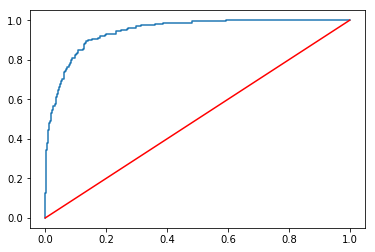

In [128]:
pred_class_blr = (pred_probs_blr > .5)

AccRate_MLE = np.sum(predict_class==y_test['default'])/len(y_test) 
LS_MLE = -(y_test.T.dot(np.log(pred_probs_blr))+(1-y_test).T.dot(np.log(1-pred_probs_blr)))

print(AccRate_MLE, LS_MLE)
#print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,pred_probs_blr)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,pred_probs_blr)
print(AUC_MLE)

### Linear Discriminant Analysis

In [129]:
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)
clf.fit(X_train, y_train['default'])
print(clf.means_, clf.priors_, clf.covariance_)
pred_probs_lda = clf.predict_proba(X_test)
pred_probs_lda = pred_probs_lda[:,1]

[[1.00000000e+00 8.01750154e+02 3.36653730e+04]
 [1.00000000e+00 1.75613784e+03 3.16574825e+04]] [0.9652 0.0348] [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.02757074e+05 -9.05741455e+05]
 [ 0.00000000e+00 -9.05741455e+05  1.77606155e+08]]


#### Assess predictive ability

0.9742 default    397.126452
dtype: float64
0.9435950002533392


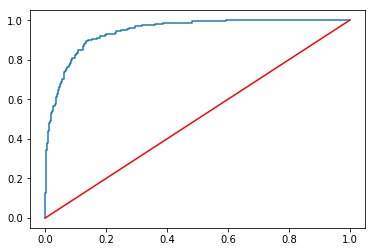

In [131]:
pred_class_lda = (pred_probs_lda > .5)

AccRate_LDA = np.sum(pred_class_lda==y_test['default'])/len(y_test) 
LS_LDA = -(y_test.T.dot(np.log(pred_probs_lda))+(1-y_test).T.dot(np.log(1-pred_probs_lda)))

print(AccRate_LDA, LS_LDA)
#print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,pred_probs_lda)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,pred_probs_lda)
print(AUC_MLE)